In [315]:
from pymongo import MongoClient
import pprint
import pandas as pd
# Requests sends and recieves HTTP requests.
import requests
import json
import time
from scipy import stats
import numpy as np
plt.style.use('ggplot')

In [3]:
import matplotlib.pyplot as plt

In [4]:
client = MongoClient('localhost', 27017)
results = client['results']
runners = results['indiv']
new = client['new_db']
indiv = new['individual']

In [5]:
results.list_collection_names()

['indiv', 'source']

In [6]:
len(list(runners.find()))

19311

In [7]:
### Create dataframe from indiv results collection, converts time to seconds
df = pd.DataFrame(list(runners.find()))
df.head()
df['Time(sec)'] = pd.to_timedelta(df['time']).astype('timedelta64[s]').astype(int)#.map('{:,.2f}'.format)
df.head()

,_id,name,time,age,ag,dist,Time(sec)
0,5f170b3bc94e506c54092382,Abdi Abdirahman,2:11:34,42,Men 40-44,Mar,7894
1,5f170b3bc94e506c54092383,Mustafa Mohamed,2:19:41,40,Men 40-44,Mar,8381
2,5f170b3bc94e506c54092384,Fredison Costa,2:21:29,42,Men 40-44,Mar,8489
3,5f170b3bc94e506c54092385,Vladimir Shatrov,2:26:17,41,Men 40-44,Mar,8777
4,5f170b3bc94e506c54092386,Miguel Ferrer,2:27:15,41,Men 40-44,Mar,8835


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19311 entries, 0 to 19310
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   _id        19311 non-null  object
 1   name       19311 non-null  object
 2   time       19311 non-null  object
 3   age        19311 non-null  int64 
 4   ag         19311 non-null  object
 5   dist       19311 non-null  object
 6   Time(sec)  19311 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.0+ MB


In [20]:
##set up 4 diff DF
agroup = ['Men 40-44', 'Men 45-49', 'Women 25-29', 'Women 30-34']
dist = ['Mar', 'Mar', 'Mile', 'Mile']

#M_Mar = df[df['ag']=='Men 40-44'& df['dist']=='Mar']

M_Mar = df[df.ag.isin(agroup[:2]) & 
           df.dist.isin(dist[:2])]
W_Mar = df[df.ag.isin(agroup[2:]) & 
           df.dist.isin(dist[:2])]
M_Mile = df[df.ag.isin(agroup[:2]) & 
           df.dist.isin(dist[2:])]
W_Mile = df[df.ag.isin(agroup[2:]) & 
           df.dist.isin(dist[2:])]

In [239]:
def add_quantile(df):
    cutoff = df['Time(sec)'].quantile(.75)
    df['upper quartiles'] = df['Time(sec)']<cutoff
    return df['upper quartiles']

    
raw_list_df = [M_Mar, W_Mar, M_Mile, W_Mile]

quant_list = [add_quantile(x) for x in raw_list_df]

quant_list[0].tail()
quant_list[1].describe()






/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


count     7055
unique       2
top       True
freq      5289
Name: upper quartiles, dtype: object

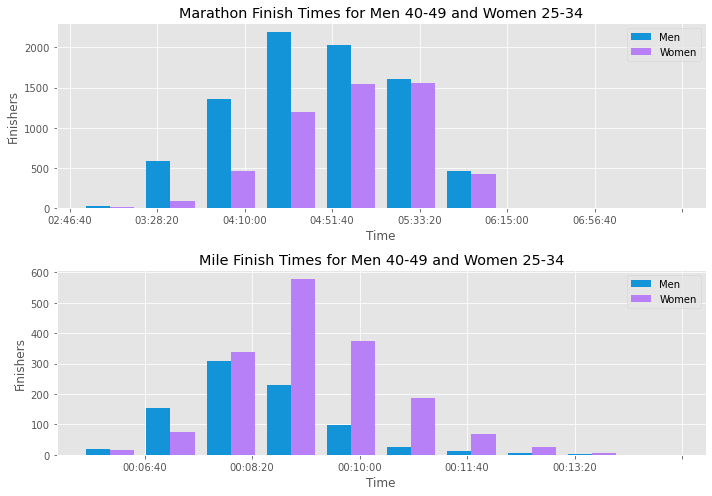

In [250]:
## creates functions for histograms, one with raw data and one density function
secs_mile = [300, 400, 500, 600, 700, 800]
secs_mar = [7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000]

def formatTime(ls):
    l = []
    for i in ls:
        l.append(time.strftime('%H:%M:%S', time.gmtime(i)))
    return l

## creates functions for histograms, one with raw data and one density function.  
##requires data for 4 races, and density variable

def plot_histograms(data, x_labels_mar, x_labels_mile, density = False):
    fig,ax = plt.subplots(2, 1, figsize = (10, 7))

## marathon data
    ax[0].hist([data[0], data[1]], bins = 10, range = (7800,25000), density = density, align = ('mid'), color = ['#1494D8','#B780F6'], label = ['Men', 'Women'])   
    ax[0].spines["bottom"].set_visible(True)      
    ax[0].spines["left"].set_visible(True)
#plt.xticks(fontsize=30)
    if density == True:
        ax[0].set_title('Marathon Finish Times for Men 40-49 and Women 25-24 as Density Functions')
        ax[1].set_yticklabels([])
    else:
        ax[0].set_title('Marathon Finish Times for Men 40-49 and Women 25-34')
        ax[0].set_ylabel('Finishers')
    ax[0].set_xlabel('Time')

    #ax[0].set_xticks(format_time(secs))
    ax[0].set_xticklabels(x_labels_mar)
    ax[0].legend()
##
    ax[1].hist([data[2], data[3]], bins = 10, range = (240,800), density = density, align = ('mid'), color = ['#1494D8','#B780F6'], label = ['Men', 'Women'])   
    ax[1].spines["bottom"].set_visible(True)      
    ax[1].spines["left"].set_visible(True)
#plt.xticks(fontsize=30)
    if density == True:
        ax[1].set_title('Mile Finish Times for Men 40-49 and Women 25-24 as Density Functions')
        ax[1].set_yticklabels([])
    else:
        ax[1].set_title('Mile Finish Times for Men 40-49 and Women 25-34')
        ax[1].set_ylabel('Finishers')
    ax[1].set_xlabel('Time')
    ax[1].set_xticklabels(x_labels_mile)
    ax[1].legend()

    fig.tight_layout()

plot_histograms(quant_list, formatTime(secs_mar), formatTime(secs_mile))
plot_histograms(quant_list, formatTime(secs_mar), formatTime(secs_mile), True)


In [195]:
men_mean = round(quant_list[0]['Time(sec)'].mean())
men_std = round(quant_list[0]['Time(sec)'].std())

women_mean = round(quant_list[1]['Time(sec)'].mean())
women_std = round(quant_list[1]['Time(sec)'].std())

#print(stats.shapiro(quant_list[0]['Time(sec)']))

def calculate_t_test(sample1, sample2, type_I_error_rate):
    ttest = stats.ttest_ind(sample1, sample2, equal_var = False)
    return (ttest[1], ttest[1] < type_I_error_rate)

error = .05
print(calculate_t_test((quant_list[0])['Time(sec)'], (quant_list[1])['Time(sec)'], error/2))
# print(results)
print('''The mean of the men's times is {} with a standard deviation of {}. 
For the women, the mean is {} with a standard deviation of {}. 
Using a t-test with {} significance, we get a p-value of {} meaning that the null hypothesis is {}.'''.format(men_mean, men_std, women_mean, women_std, 1- error, results[0], results == False)) 

(6.172639721380716e-150, True)
The mean of the men's times is 15653 with a standard deviation of 3235. 
For the women, the mean is 16992 with a standard deviation of 3253. 
Using a t-test with 0.95 significance, we get a p-value of 6.172639721380716e-150 meaning that the null hypothesis is False.


14659 2222
15534 1953


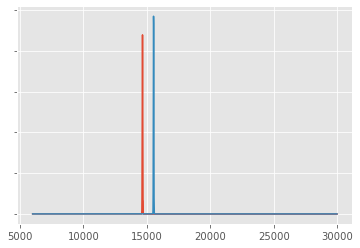

In [277]:
x = np.arange(6000, 30000, 10)
men = stats.norm(men_mean, men_std/np.sqrt(15000))
print(men_mean, men_std)
women = stats.norm(women_mean, women_std/np.sqrt(15000))
print(women_mean, women_std)

fig,ax = plt.subplots()
ax.plot(x, men.pdf(x))
ax.plot(x, women.pdf(x))
ax.set_yticklabels([])
statistic = men.ppf(.975)
ax.fill_between(x, men.pdf(x), where=(x >= statistic), color="red", alpha=0.5)

In [202]:
Null : performance is same
Alt: : performance is different

In order to determine that men perform differently than women, the mean of the women's group must have been greater than 21900.

SyntaxError: invalid syntax (<ipython-input-202-39f7527e8f6a>, line 2)

In [204]:
M_Mar['name'].str.title()

0        Abdi Abdirahman
1        Mustafa Mohamed
2         Fredison Costa
3       Vladimir Shatrov
4          Miguel Ferrer
              ...       
9696    Derrick Lawrence
9697         Paul Biguvu
9698    Joseph Frederick
9699        Steve Dubois
9700        Tane Walters
Name: name, Length: 9701, dtype: object

In [205]:
type(M_Mar['name'])

pandas.core.series.Series

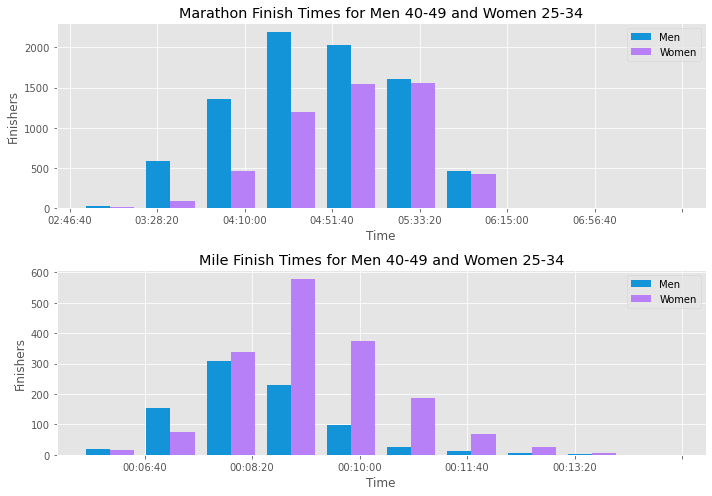

In [251]:
def sub_12(df):
    df_new = df[df['Time(sec)']<18864]
    return df_new['Time(sec)']

def sub_12_mile(df):
    df_new = df[df['Time(sec)']< 720]
    return df_new['Time(sec)']
sub_12_list = [sub_12(M_Mar), sub_12(W_Mar), sub_12_mile(M_Mile), sub_12_mile(W_Mile)]

plot_histograms(sub_12_list, formatTime(secs_mar), formatTime(secs_mile))


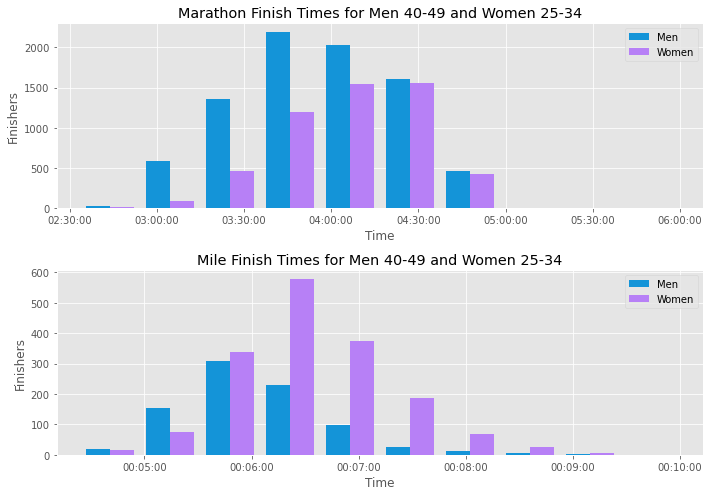

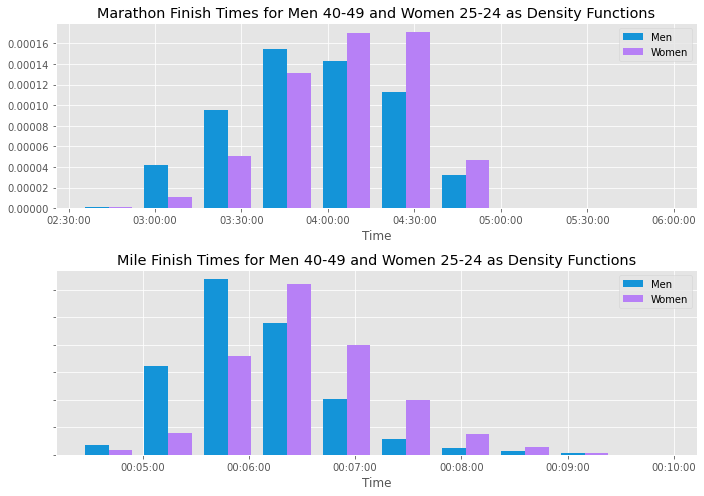

In [267]:
x = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
twelve_sec = []
for i in x:
    twelve_sec.append(i*3600)

mar_x = format_time(twelve_sec)
mile_x = format_time([4*60, 5*60, 6*60, 7*60, 8*60, 9*60, 10*60, 11*60, 12*60])

plot_histograms(sub_12_list, mar_x, mile_x)
plot_histograms(sub_12_list, mar_x, mile_x, density = True)

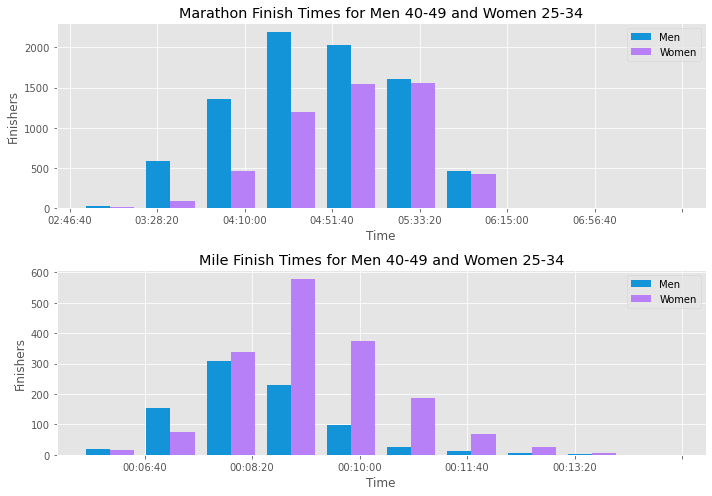

In [274]:
## marathon comparison t-test
men_mean = round(sub_12_list[0].mean())
men_std = round(sub_12_list[0].std())

women_mean = round(sub_12_list[1].mean())
women_std = round(sub_12_list[1].std())

#print(stats.shapiro(quant_list[0]['Time(sec)']))

def calculate_t_test(sample1, sample2, type_I_error_rate):
    ttest = stats.ttest_ind(sample1, sample2, equal_var = False)
    return (ttest[1], ttest[1] < type_I_error_rate)

error = 
print(calculate_t_test(sub_12_list[0], sub_12_list[1], error/2))
# print(results)
print('''The mean of the men's times is {} with a standard deviation of {}. 
For the women, the mean is {} with a standard deviation of {}. 
Using a t-test with {} significance, we get a p-value of {} meaning that the null hypothesis is {}.'''.format(men_mean, men_std, women_mean, women_std, 1- error, results[0], results == False)) 

(2.134255115432781e-125, True)
The mean of the men's times is 14659 with a standard deviation of 2222. 
For the women, the mean is 15534 with a standard deviation of 1953. 
Using a t-test with 0.09999999999999998 significance, we get a p-value of 6.172639721380716e-150 meaning that the null hypothesis is False.


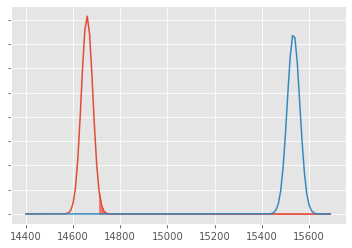

In [284]:
x = np.arange(14400, 15700, 10)
men = stats.norm(sub_12_list[0].mean(), sub_12_list[0].std()/np.sqrt(sub_12_list[0].count()))
women = stats.norm(sub_12_list[1].mean(), sub_12_list[1].std()/np.sqrt(sub_12_list[1].count()))

fig,ax = plt.subplots()
ax.plot(x, men.pdf(x))
ax.plot(x, women.pdf(x))
ax.set_yticklabels([])
statistic = men.ppf(.975)
ax.fill_between(x, men.pdf(x), where=(x >= statistic), color="red", alpha=0.5)

In [312]:
#df_repeats = M_Mar[M_Mar['name'] in ['Alexander Hoyt']]

df_repeats = M_Mar[M_Mar['name'].isin(list(M_Mile['name']))]

#df_new[df_new['l_ext'].isin([31, 22, 30, 25, 64])]

df_repeats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 104 to 9689
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   _id              354 non-null    object
 1   name             354 non-null    object
 2   time             354 non-null    object
 3   age              354 non-null    int64 
 4   ag               354 non-null    object
 5   dist             354 non-null    object
 6   Time(sec)        354 non-null    int64 
 7   upper quartiles  354 non-null    bool  
 8   sub12            354 non-null    bool  
dtypes: bool(2), int64(2), object(5)
memory usage: 22.8+ KB


In [321]:
a = set(M_Mar['name'].values)


In [325]:
len(M_Mar['name'].unique())

9645

In [326]:
len(M_Mar['name'])

9701

In [327]:
len(W_Mar['name'].unique())

7031

In [328]:
len(W_Mar['name'])

7055

In [350]:
mmat = M_Mar[M_Mar['Time(sec)']<18864]
wmat = W_Mar[W_Mar['Time(sec)']<18864]
mmit = M_Mile[M_Mile['Time(sec)']<720]
wmit = W_Mile[W_Mile['Time(sec)']<720]

mmat['nameage'] =  mmat['age'].astype(str) + mmat["name"]
wmat['nameage'] = wmat['age'].astype(str) + wmat["name"]
mmit['nameage'] = mmit['age'].astype(str) + mmit["name"]
wmit['nameage'] = wmit['age'].astype(str) + wmit["name"]



repeats_m = pd.merge(left=mmat, right=mmit, left_on='nameage', right_on='nameage')
repeats_w = pd.merge(left=wmat, right=wmit, left_on='nameage', right_on='nameage')

/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,_id_x,name_x,time_x,age_x,ag_x,dist_x,Time(sec)_x,upper quartiles_x,normalized_time,nameage,_id_y,name_y,time_y,age_y,ag_y,dist_y,Time(sec)_y,upper quartiles_y
0,5f17166fc94e506c54094977,Emily Goldsmith,2:56:01,29,Women 25-29,Mar,10561,True,14521.936357,29Emily Goldsmith,5f171bebc94e506c5409650c,Emily Goldsmith,0:05:15,29,Women 25-29,Mile,315,True
1,5f17166fc94e506c54094979,Lena Placzek,2:56:26,27,Women 25-29,Mar,10586,True,14556.312686,27Lena Placzek,5f171bebc94e506c54096505,Lena Placzek,0:04:58,27,Women 25-29,Mile,298,True
2,5f17166fc94e506c5409497f,Mary Johnston,2:58:11,26,Women 25-29,Mar,10691,True,14700.693267,26Mary Johnston,5f171bebc94e506c5409650e,Mary Johnston,0:05:18,26,Women 25-29,Mile,318,True
3,5f17166fc94e506c540949b1,Amanda Fox,3:11:30,29,Women 25-29,Mar,11490,True,15799.360737,29Amanda Fox,5f171bebc94e506c54096525,Amanda Fox,0:05:42,29,Women 25-29,Mile,342,True
4,5f17166fc94e506c540949d4,Kaitlyn DiBello,3:17:17,28,Women 25-29,Mar,11837,True,16276.504181,28Kaitlyn DiBello,5f171bebc94e506c54096513,Kaitlyn DiBello,0:05:26,28,Women 25-29,Mile,326,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,5f171b16c94e506c540960f5,Ksenia Stepanova,5:10:10,34,Women 30-34,Mar,18610,True,25589.739192,34Ksenia Stepanova,5f171cc0c94e506c54096af1,Ksenia Stepanova,0:08:55,34,Women 30-34,Mile,535,False
222,5f171b16c94e506c54096102,Kristen Mogavero,5:10:58,34,Women 30-34,Mar,18658,True,25655.741743,34Kristen Mogavero,5f171cbfc94e506c54096a4d,Kristen Mogavero,0:08:00,34,Women 30-34,Mile,480,True
223,5f171b16c94e506c54096111,Nicole Lauterbach,5:11:39,32,Women 30-34,Mar,18699,True,25712.118923,32Nicole Lauterbach,5f171cbfc94e506c54096a21,Nicole Lauterbach,0:07:49,32,Women 30-34,Mile,469,True
224,5f171b16c94e506c5409611b,Jennifer Coyne,5:12:06,30,Women 30-34,Mar,18726,True,25749.245358,30Jennifer Coyne,5f171cbfc94e506c540969e6,Jennifer Coyne,0:07:34,30,Women 30-34,Mile,454,True


In [349]:
repeats_w.describe()

,age_x,Time(sec)_x,normalized_time,age_y,Time(sec)_y
count,226.000000,226.000000,226.000000,226.000000,226.000000
mean,29.530973,15470.663717,21272.984935,29.530973,415.530973
std,2.781113,1995.534455,2743.965946,2.781113,49.266273
min,25.000000,8847.000000,12165.095252,25.000000,298.000000
25%,27.000000,14208.250000,19537.098972,27.000000,384.250000
50%,29.000000,15485.500000,21293.385613,29.000000,411.000000
75%,32.000000,17095.750000,23507.564954,32.000000,435.000000
max,34.000000,18826.000000,25886.750673,34.000000,621.000000
